# Code for running XGBoost based predition model. we have used Kmeans clustering approach to spatially seperate the observations so that we can choose training and test data independently without data leakage.

# import packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
import geopandas as gpd

# Load data

In [9]:
# Load your data
df = pd.read_excel(
    "D:/2nd_paper_relationship_RS_fielddata/Data_calculation/soil_biomass_data_all_years/work_combining_Field_RS_data/Dat_IPP-N_TH.xlsx",
    sheet_name="Tabelle1"
)

# Encode categorical variable 'Crop'
df['Crop'] = df['Crop'].astype('category')
df['Crop_encoded'] = df['Crop'].cat.codes

# Print crop-to-code mapping
print("Crop Encoding Mapping:")
for code, name in enumerate(df['Crop'].cat.categories):
    print(f"{name}: {code}")

# Drop missing values for relevant columns
predictor_columns = ['elev', 'aspect', 'slope', 
                     'Green-II', 'Red', 'Red-edge', 'NIR', 'NDVI', 'RDVI', 'RedEdge2', 
                     'GNDVI', 'NDRE', 'EVI2', 'Leaf chlorophyll index (LCI)', 'MSAVI2', 
                     'Red-Edge Chlorophyll Index (Cl)', 'Green Chlorophyll Index (Cl)', 
                     'MSR', 'MSR-RE', 'NIR/RE', 'NIR/R', 'Precipitation', 'Accumulated_PAR',
                     'Crop_encoded', 'BBCH', 'Days_Count']
target_column = "Bio_Dm"
df = df.dropna(subset=predictor_columns + [target_column, 'Crop', 'X', 'Y'])
df

Crop Encoding Mapping:
Barley: 0
Maize: 1
Rapeseed: 2
Rye: 3
Sunflower: 4
Wheat: 5


,Patch,Crop,Crop_code,Sampling date,Date_Order,Sowing date,BBCH,year,Mp,Type,...,Red-Edge Chlorophyll Index (Cl),Green Chlorophyll Index (Cl),MSR,MSR-RE,NIR/RE,NIR/R,Precipitation,Accumulated_PAR,Days_Count,Crop_encoded
0,21,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.664105,5.485714,2.584770,1.233579,3.664105,9.292398,361.2,8520.0,218,2
1,39,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.859016,5.833091,2.600750,1.297007,3.859016,9.378486,361.2,8520.0,218,2
2,73,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.551036,5.227456,2.392193,1.195808,3.551036,8.292115,361.2,8520.0,218,2
3,Ref1_Con,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,Ref_Con,...,2.393443,4.697248,2.067832,1.141880,3.393443,6.760498,361.2,8520.0,218,2
4,Ref1_Red,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,Ref_Red,...,2.377778,5.071904,2.250581,1.136434,3.377778,7.600000,361.2,8520.0,218,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,51,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,2.023501,4.314815,2.078621,1.008791,3.023501,6.808394,195.0,33697.0,82,4
571,102,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,2.374711,4.604353,2.204173,1.135366,3.374711,7.381113,195.0,33697.0,82,4
572,114,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,1.927936,3.769565,1.777768,0.972771,2.927936,5.549747,195.0,33697.0,82,4
573,Ref5_Con,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,Ref_Con,...,2.351574,4.445798,2.359502,1.127290,3.351574,8.129091,195.0,33697.0,82,4


# creating spatial clusters with Kmeans clustering to select training and test dataset

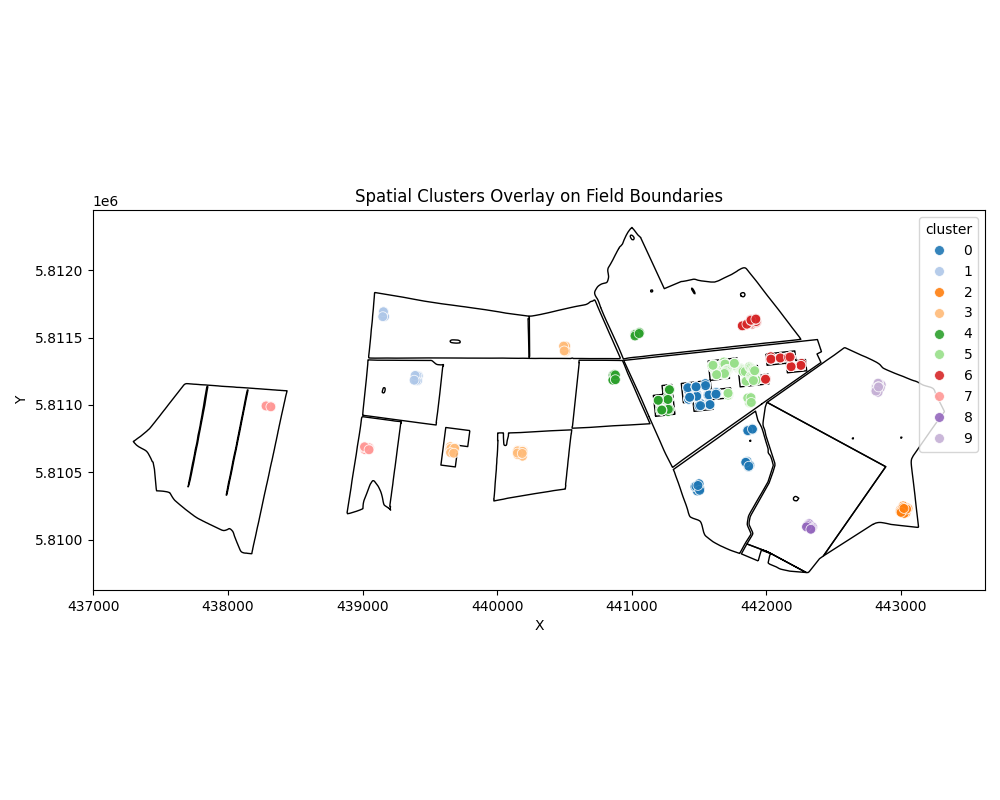


📍 Cluster distribution:
cluster
5    214
0    104
6     68
4     67
3     40
2     18
9     14
7     14
1     14
8     10
Name: count, dtype: int64


In [10]:
# Spatial Clustering with KMeans
kmeans = KMeans(n_clusters=10, random_state=50)
df['cluster'] = kmeans.fit_predict(df[['X', 'Y']])

# Visualize Clusters with Shapefile
shp_path = "D:/2nd_paper_relationship_RS_fielddata/GIS_RS_dataset/shp_files/Tempelberg_all_fields/Tempelberg_fields_with_observations.shp"
gdf_fields = gpd.read_file(shp_path)

plt.figure(figsize=(10, 8))
gdf_fields.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
sns.scatterplot(data=df, x='X', y='Y', hue='cluster', palette='tab20', s=50, alpha=0.9)
plt.title("Spatial Clusters Overlay on Field Boundaries")
plt.grid(False)
plt.tight_layout()
plt.show()

print("\n📍 Cluster distribution:")
print(df['cluster'].value_counts())

# Select training and Test data

In [11]:
# Select Cluster(s) for Test Set
test_clusters = [1,2,3,4,7,8,9]
test_df = df[df['cluster'].isin(test_clusters)].copy()
train_df = df[~df['cluster'].isin(test_clusters)].copy()

print("\n🔹 Train samples by crop:")
print(train_df['Crop'].value_counts())
print("\n🔹 Test samples by crop:")
print(test_df['Crop'].value_counts())
print(test_clusters)
# Train/Test Split
X_train = train_df[predictor_columns]
y_train = train_df[target_column]
X_test = test_df[predictor_columns]
y_test = test_df[target_column]


🔹 Train samples by crop:
Crop
Maize        98
Rapeseed     68
Rye          68
Sunflower    54
Barley       52
Wheat        46
Name: count, dtype: int64

🔹 Test samples by crop:
Crop
Barley       40
Wheat        36
Rapeseed     33
Sunflower    28
Maize        26
Rye          14
Name: count, dtype: int64
[1, 2, 3, 4, 7, 8, 9]


# Setting hyperparameters for the XGBoost 

In [12]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.3, 0.5, 1],
    'colsample_bytree': [0.1, 0.5, 1],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2]
}

# running XGBoost in 5-fold

In [13]:
# KFold Cross-Validation + Randomized Search
kf = KFold(n_splits=5, shuffle=True, random_state=50)
best_params_list = []
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n🔁 Fold {fold + 1}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgbmodel = XGBRegressor(objective='reg:squarederror', random_state=50)
    random_search = RandomizedSearchCV(
        estimator=xgbmodel,
        param_distributions=param_dist,
        n_iter=900,  # You can adjust this depending on your compute capacity, according to my param_dist I have 3*7 =2187 putting them with 5 fold would too much, so I choose, n_iter= 1000
        scoring='r2',
        cv=5,
        random_state=50,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X_tr, y_tr)

    best_model = random_search.best_estimator_
    val_preds = best_model.predict(X_val)
    r2 = r2_score(y_val, val_preds)
    print(f"Best Params: {random_search.best_params_}, R2: {r2:.3f}")

    best_params_list.append(random_search.best_params_)
    cv_scores.append(r2)


🔁 Fold 1
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5}, R2: 0.842

🔁 Fold 2
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5}, R2: 0.823

🔁 Fold 3
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'subsample': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.5}, R2: 0.878

🔁 Fold 4
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.1}, R2: 0.749

🔁 Fold 5
Fitting 5 folds for each of 900 candidates, totallin

# the most-happened hyperparameter combination

In [14]:
from collections import Counter
most_common_params = Counter([frozenset(p.items()) for p in best_params_list]).most_common(1)[0][0]
final_params = dict(most_common_params)
print(f"\n✅ Most Common Hyperparameters: {final_params}")


✅ Most Common Hyperparameters: {'reg_alpha': 1, 'subsample': 0.5, 'learning_rate': 0.1, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 6, 'colsample_bytree': 0.5}


# applying the trainined model on test data and check model performence on individual crops

In [15]:
final_model = XGBRegressor(**final_params, random_state=50)
final_model.fit(X_train, y_train)
test_preds = final_model.predict(X_test)

import joblib
joblib.dump(final_model, "trained_xgb_model.pkl")

print("\n📊 Test Set Performance:")
print("R²:", r2_score(y_test, test_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("MAE:", mean_absolute_error(y_test, test_preds))

# Per-Crop Performance
test_df = test_df.assign(Predicted=test_preds)
crop_scores = test_df.groupby("Crop").apply(
    lambda d: pd.Series({
        "R2": r2_score(d[target_column], d["Predicted"]),
        "RMSE": np.sqrt(mean_squared_error(d[target_column], d["Predicted"])),
        "MAE": mean_absolute_error(d[target_column], d["Predicted"])
    })
).round(3)

print("\n📊 Per-Crop Performance:")
print(crop_scores)


📊 Test Set Performance:
R²: 0.8323071542755094
RMSE: 0.4439287606436146
MAE: 0.3218190531442933

📊 Per-Crop Performance:
              R2   RMSE    MAE
Crop                          
Barley     0.873  0.314  0.241
Maize      0.946  0.255  0.198
Rapeseed   0.856  0.408  0.302
Rye        0.525  0.517  0.421
Sunflower  0.632  0.747  0.594
Wheat      0.886  0.350  0.269


# SHAP plots to understand feature importance


🔍 Running SHAP analysis...


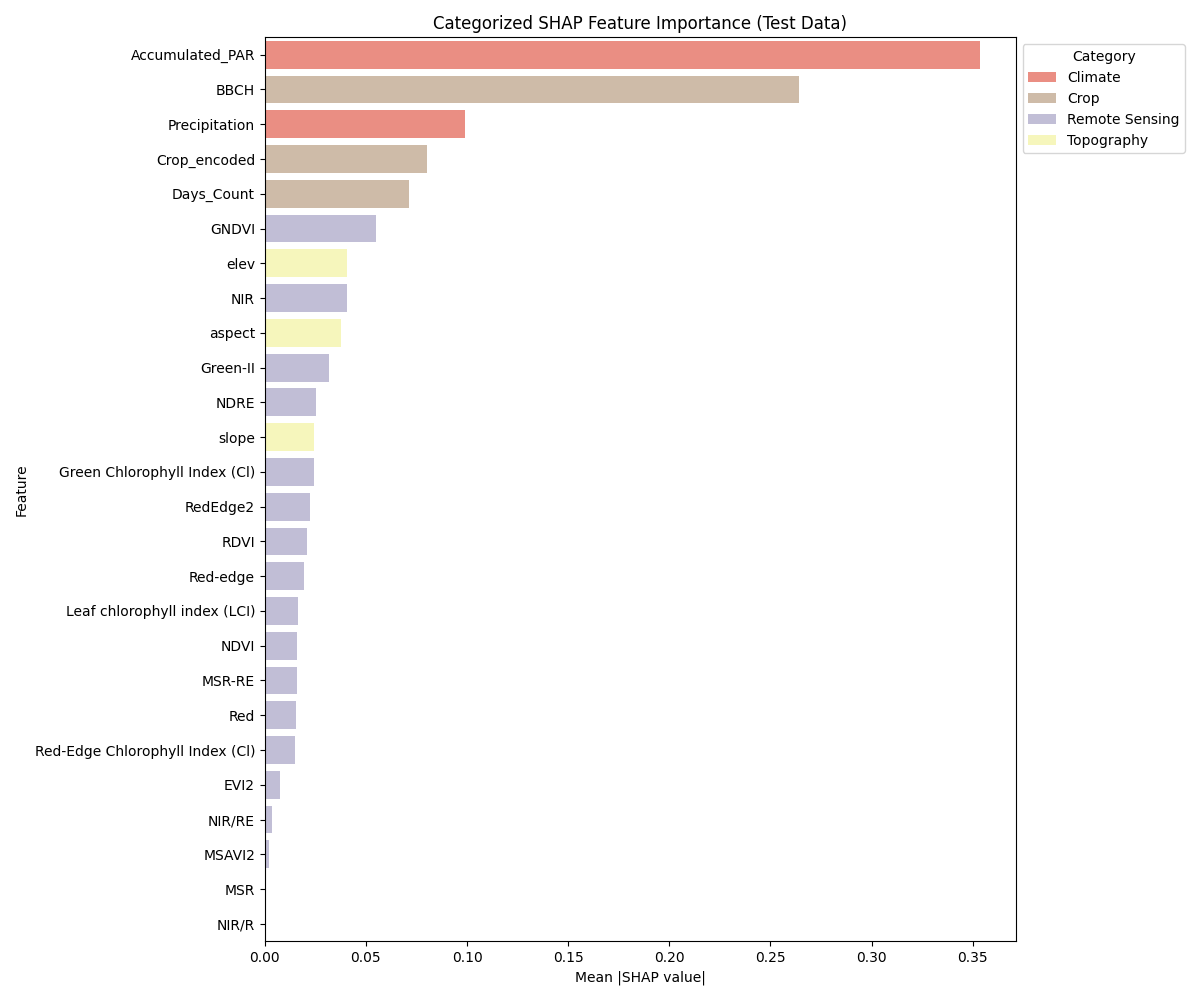


🎯 Creating SHAP beeswarm plot...


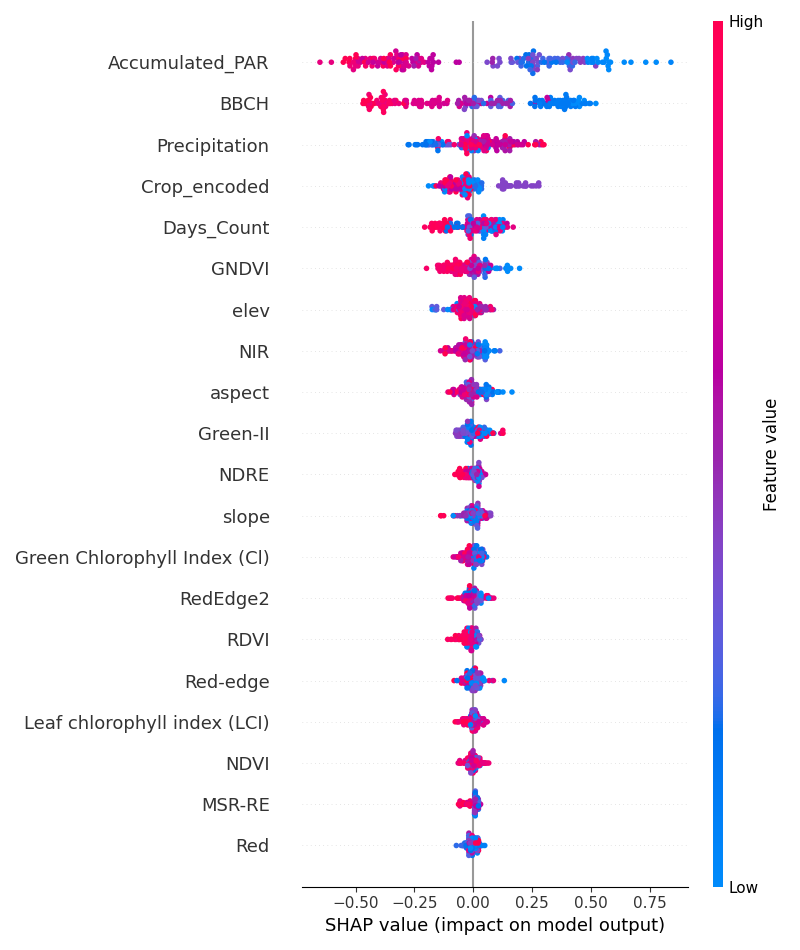

In [16]:
# ========================
print("\n🔍 Running SHAP analysis...")

explainer = shap.TreeExplainer(final_model)
shap_values_test = explainer.shap_values(X_test)

# Handle SHAP output format
if isinstance(shap_values_test, list):
    shap_values_test = shap_values_test[0]

# Define feature categories
feature_categories = {
    'Soil moisture': 'Soil', 'Sand': 'Soil', 'Silt': 'Soil', 'Clay': 'Soil',
    'elev': 'Topography', 'aspect': 'Topography', 'slope': 'Topography',
    'Green-II': 'Remote Sensing', 'Red': 'Remote Sensing', 'Red-edge': 'Remote Sensing', 'NIR': 'Remote Sensing',
    'NDVI': 'Remote Sensing', 'RDVI': 'Remote Sensing', 'RedEdge2': 'Remote Sensing',
    'GNDVI': 'Remote Sensing', 'NDRE': 'Remote Sensing', 'EVI2': 'Remote Sensing',
    'Leaf chlorophyll index (LCI)': 'Remote Sensing', 'MSAVI2': 'Remote Sensing',
    'Red-Edge Chlorophyll Index (Cl)': 'Remote Sensing', 'Green Chlorophyll Index (Cl)': 'Remote Sensing',
    'MSR': 'Remote Sensing', 'MSR-RE': 'Remote Sensing', 'NIR/RE': 'Remote Sensing', 'NIR/R': 'Remote Sensing',
    'Precipitation': 'Climate', 'Accumulated_PAR': 'Climate',
    'Crop_encoded': 'Crop', 'Days_Count': 'Crop', 'BBCH': 'Crop'
}

# Mean Absolute SHAP
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP': np.abs(shap_values_test).mean(axis=0)
})
shap_importance['Category'] = shap_importance['Feature'].map(feature_categories)
shap_importance = shap_importance.sort_values('Mean_Abs_SHAP', ascending=False)

# Color palette
palette = {
    'Soil': '#8dd3c7', 'Topography': '#ffffb3', 'Remote Sensing': '#bebada',
    'Climate': '#fb8072', 'Crop': '#d4bba2'
}

# Plot Categorized Barplot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=shap_importance,
    y='Feature',
    x='Mean_Abs_SHAP',
    hue='Category',
    palette=palette,
    dodge=False
)
plt.title("Categorized SHAP Feature Importance (Test Data)")
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Feature")
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# SHAP Beeswarm Plot
print("\n🎯 Creating SHAP beeswarm plot...")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_test, X_test, plot_type="dot", show=True)

# scatter plots 


📈 Creating scatter plots...


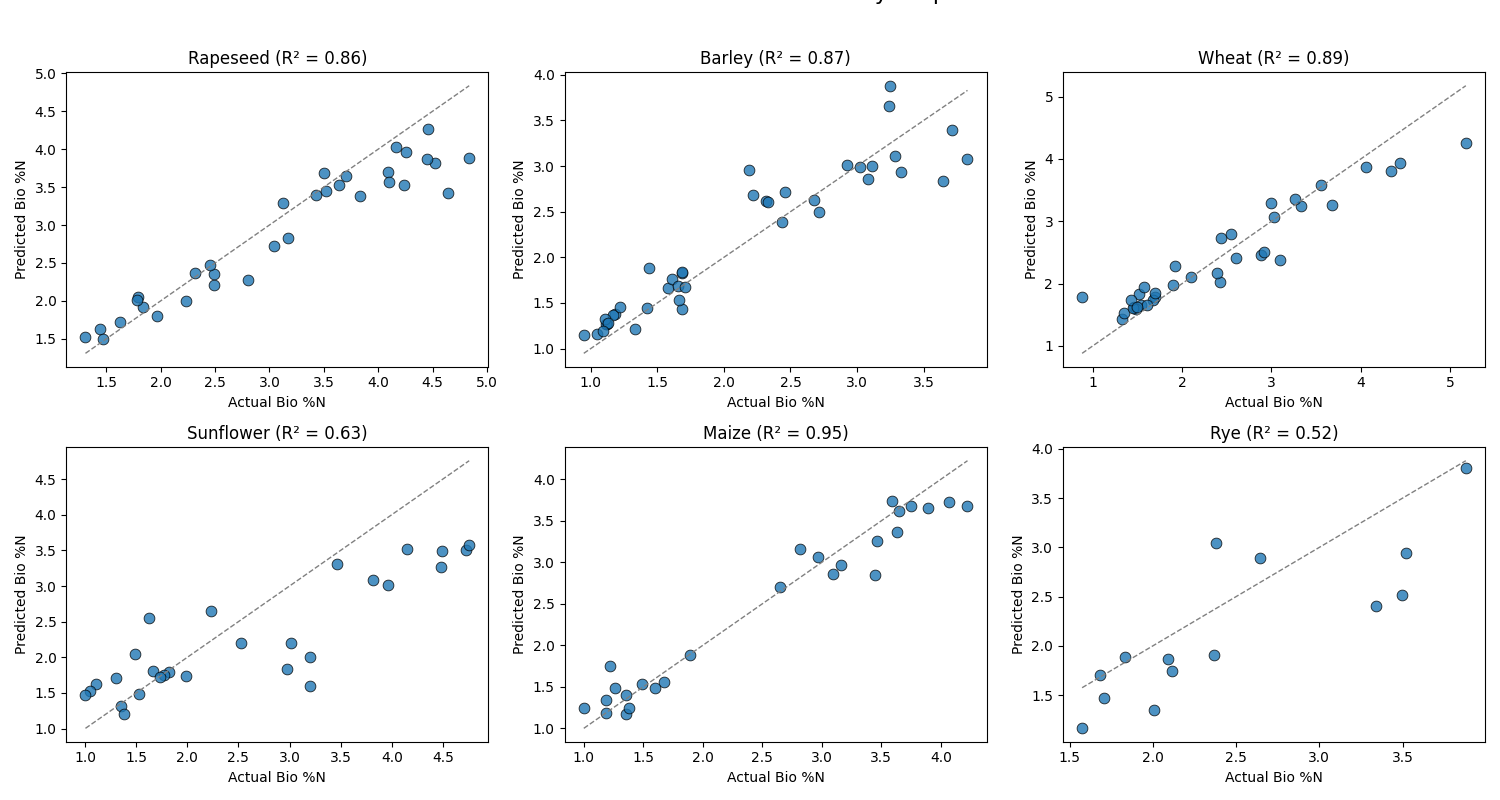

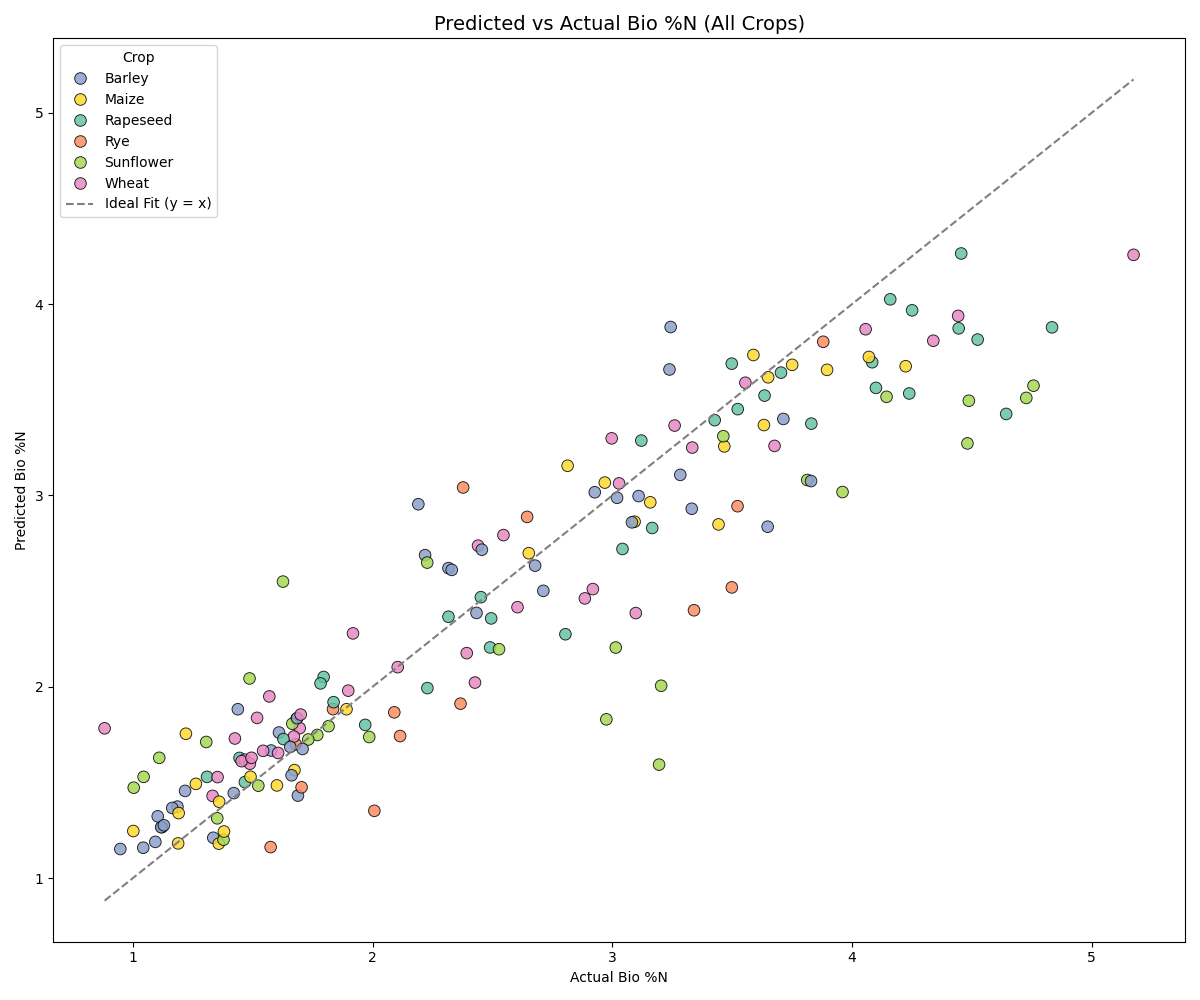

In [17]:
# ========================
print("\n📈 Creating scatter plots...")

# Prepare summary dataframe
summary_df = test_df[['Crop', 'Bio %N', 'Predicted']].rename(columns={'Bio %N': 'Actual'})

# Per-Crop Scatter Plots
unique_crops = summary_df['Crop'].unique()
n_crops = len(unique_crops)
n_cols = 3
n_rows = int(np.ceil(n_crops / n_cols))

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, crop in enumerate(unique_crops):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    crop_data = summary_df[summary_df["Crop"] == crop]
    sns.scatterplot(data=crop_data, x="Actual", y="Predicted", s=60, edgecolor='k', alpha=0.8, ax=ax)
    ax.plot([crop_data["Actual"].min(), crop_data["Actual"].max()],
            [crop_data["Actual"].min(), crop_data["Actual"].max()],
            color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{crop} (R² = {r2_score(crop_data['Actual'], crop_data['Predicted']):.2f})")
    ax.set_xlabel("Actual Bio %N")
    ax.set_ylabel("Predicted Bio %N")
plt.suptitle("Actual vs Predicted Bio %N by Crop", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Overall Scatter Plot
# Custom color palette for consistent crop colors
custom_palette = {
    'Rapeseed': '#66c2a5',
    'Rye': '#fc8d62',
    'Barley': '#8da0cb',
    'Wheat': '#e78ac3',
    'Sunflower': '#a6d854',
    'Maize': '#ffd92f'
}

# Overall Scatter Plot with custom colors
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=summary_df,
    x="Actual",
    y="Predicted",
    hue="Crop",
    palette=custom_palette,
    s=70,
    edgecolor='k',
    alpha=0.85
)

# Diagonal line
min_val = min(summary_df["Actual"].min(), summary_df["Predicted"].min())
max_val = max(summary_df["Actual"].max(), summary_df["Predicted"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1.5, label="Ideal Fit (y = x)")

plt.title("Predicted vs Actual Bio %N (All Crops)", fontsize=14)
plt.xlabel("Actual Bio %N")
plt.ylabel("Predicted Bio %N")
plt.legend(title="Crop", bbox_to_anchor=(0, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

# bootstrapping to check model stability


🎲 Running bootstrapping for model stability...


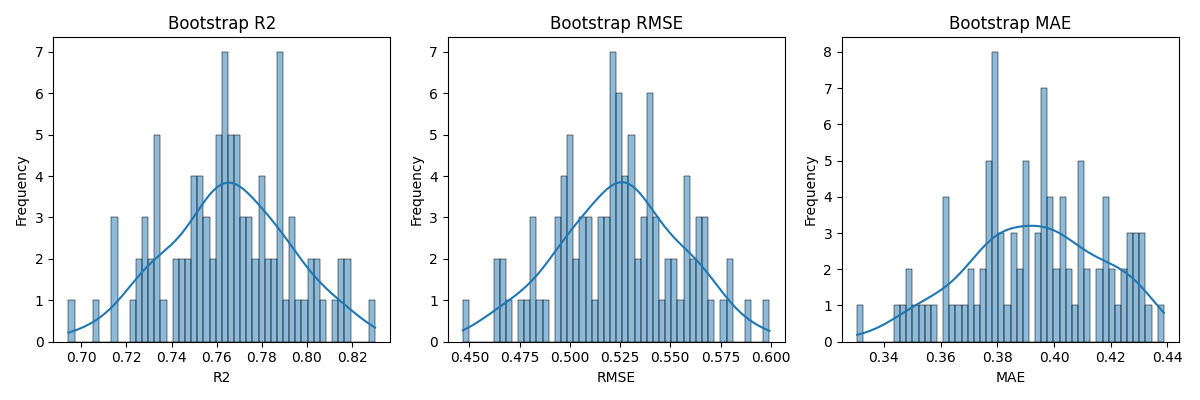


📈 Bootstrap Summary Statistics:
            R2     RMSE      MAE
count  100.000  100.000  100.000
mean     0.765    0.524    0.393
std      0.027    0.031    0.024
min      0.694    0.447    0.331
25%      0.749    0.503    0.377
50%      0.765    0.525    0.395
75%      0.785    0.543    0.410
max      0.830    0.599    0.439


In [18]:
# ========================
print("\n🎲 Running bootstrapping for model stability...")

from sklearn.utils import resample

bootstrap_results = []
n_iterations = 100

for i in range(n_iterations):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + i)

    model = XGBRegressor(**final_params, random_state=42 + i)
    model.fit(X_boot, y_boot)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    bootstrap_results.append({'R2': r2, 'RMSE': rmse, 'MAE': mae})

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# Plot Bootstrap Distributions
plt.figure(figsize=(12, 4))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(bootstrap_df[metric], kde=True, bins=50)
    plt.title(f"Bootstrap {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summary stats
print("\n📈 Bootstrap Summary Statistics:")
print(bootstrap_df.describe().round(3))